# Introduction to Bayesian Optimization
**Drew Gjerstad**  

_Bayesian Optimization Series_  
[github.com/drewgjerstad/bayesian-optimization](https://github.com/drewgjerstad/bayesian-optimization)

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

## Contents
 * [Introduction](#introduction)
 * [Motivation](#motivation)
     - [Theoretical Motivation](#theoretical-motivation)
     - [Applications](#applications)
 * [Optimization Foundations](#optimization-foundations)
 * [Bayesian Foundations](#bayesian-foundations)
 * [The Bayesian Approach](#the-bayesian-approach)
 * [Bayesian Optimization Workflow](#bayesian-optimization-workflow)
 * [References](#references)

## Introduction
**Bayesian optimization** refers to an optimization approach that uses Bayesian
inference to guide the optimizer to make "better" decisions based on
_uncertainty_. One attractive feature of this approach is its _unparalleled_
sample efficiency (more on this later). Additionally, _uncertainty_ is inherent
in all optimization decisions but we can use the Bayesian approach to tackle it,
and often overcome it, in a strategic manner.

The goal of this notebook is to introduce you to Bayesian optimization from a
high-level perspective as well as introduce you to the "Bayesian optimization
workflow" and the components involved. Additional notebooks that cover these
topics in more depth can be found within the
[`bayesian-optimization`](https://github.com/drewgjerstad/bayesian-optimization)
repo. We begin with the theoretical motivation for Bayesian optimization and an
overview of its applications.

## Motivation

### Theoretical Motivation
Before we explore the applications of Bayesian optimization, we must consider
the theoretical motivation for such an approach. The theoretical motivation
typically stems from the form or type of _objective_ (the "function" we are
aiming to optimize).

 * **Black-box objective functions** are functions that we can only interact
   with via its inputs and outputs meaning typical methods do not work. However,
   we can usually approximate such an objective and use Bayesian optimization to
   manage the uncertainty.

 * **Expensive-to-evaluate objective functions** are functions that require
   significant computation effort to obtain their output. However, once again,
   we can approximate and model these efficiently using the Bayesian approach.

 * More generally, this approach is very useful when the objectives lack
   analytical evaluation (or, if analytical evaluation is expensive).

 * In some spaces such as discrete or combinatorial, the objectives may not have
   efficient gradients (if they exist) and so classical gradient-based
   optimization methods are incompatible.

There are additional supporting points to the theoretical motivation for
Bayesian optimization but these seem to be the most common, especially with
regard to the form and properties of the objective.

### Applications
The application potential of Bayesian optimization can be seen across several
critical domains, especially those attempting to accelerate finding solutions to
real-world scientific and engineering problems. Some of these applications
include:
 * Drug Discovery
 * Molecule/Protein Discovery
 * Materials Design
 * AutoML (i.e., hyperparameter tuning)
 * Engineering Decisions
 * Many more...

The images and diagrams below should help you form an idea of how Bayesian
optimization fits into some of these applications. Note that this is by no means
an exhaustive list nor should you worry too much about some of the contextual
details of the specific applications shown. This is merely to provide real-world
motivation for this optimization approach.

#### Application: Drug Discovery
The image below provides an example of optimization applied to a chemical
process problem (common in drug discovery). Don't worry about the details
regarding the formulation of the problem itself but rather consider the fact
that running chemical synthesis experiments require two things: _time_ and
_money_. Therefore, scientists want to accelerate finding optimal solutions or
in this case, optimal chemical processes/reactions.

In the bottom right of the image, four common (classical) approaches to this
optimization problem are shown. However, these approaches are likely expensive
(as mentioned previously). Therefore, the alternative approach, Bayesian
optimization, is shown in the bottom left of the image. Bayesian optimization
can use data from previous experiments to locate points (samples) that may
optimize the unknown objective, while accounting for uncertainty in the model.
These points will typically then be used to plan the next experiments since they
represent samples of high utility. In this context, high utility means the point
could be useful in optimizing the reaction parameter.

<img src="graphics/01-introduction/applications/drug-discovery.png"
     alt="Drug Discovery Application" width="600"/>

Figure from _Bayesian optimization as a tool for chemical synthesis_ by Shields
et al. (2021)

#### Application: Molecule/Protein Discovery
In the field of molecule and protein design, there are similar considerations to
the ones in the previous application: experiments are costly. In the diagram
below, the integration of Bayesian optimization with experimentation is shown.
Scientists typically synthesize and test several different formulations to build
a dataset. This dataset is used to help model the unknown objective and can be
used to suggest new formulations. As new formulations are synthesized and
tested, they are added to the dataset so as to inform the model and optimizer of
formulations to suggest next.

<img src="graphics/01-introduction/applications/molecule-protein-discovery.png"
     alt="Molecule/Protein Discovery Application" width=600/>

Figure from _Sequential closed-loop Bayesian optimization as a guide for_
_organic molecular metallophotocatalyst formulation discovery_ by Li et al.
(2024)

#### Application: Materials Discovery
The diagram below is very similar to the one for molecule/protein discovery
except now it is demonstrating some additional specifics for materials design
and discovery. Once again, the initial dataset is used to model the likely
unknown objective to inform design exploration and then the results from the
design exploration are used to augment the dataset. It appears that in this
loop, the researchers are also using the experiments to help calibrate a
simulation of designs, another application of Bayesian optimization.

<img src="graphics/01-introduction/applications/materials-design.jpg"
     alt="Materials Discovery Application" width=600/>

Figure from _Bayesian optimization for Materials Design with Mixed_
_Quantitative and Qualitative Variables_ by Zhang et al. (2020)

#### Application: AutoML
AutoML is the process of automating the machine learning workflow and often
includes tuning models' hyperparameters. Bayesian optimization can be used to
tune hyperparameters more efficiently by identifying the next hyperparameters to
test based on the current model and its quantified uncertainty. The workflow
below shows how hyperparameters for a neural network are tuned using Bayesian
optimization (using a Gaussian process as a surrogate model).

<img src="graphics/01-introduction/applications/automl.png"
     alt="AutoML Application" width=600/>

Figure from _Achieve Bayesian optimization for tuning hyperparameters_ by Edward
Ortiz on _Medium_ (2020)

#### Application: Engineering Decisions
Bayesian optimization is also useful for making engineering decisions such as
design choices to optimize hardware performance. In the diagram below, Bayesian
optimization is being used to calibrate a particle accelerator in a similar
manner as some of the previous examples. The "operator" inputs the target beam
parameters while a camera inputs the observed beam parameters. Then, Bayesian
optimization determines the changes (next set of beam parameters) to hopefully
improve the calibration of the particle accelerator.

<img src="graphics/01-introduction/applications/engineering-decisions.png"
     alt="Engineering Decisions Application" width=600/>

Figure from _Reinforcement learning-trained optimizers and Bayesian_
_optimization for online particle accelerator tuning_ by Kaiser et al. (2024)

## Optimization Foundations

In this section, we will examine the foundations of optimization to understand
the ideas and methods that Bayesian optimization builds on. This will include
formalizing optimization, objective functions, observation models, some common
optimization policies, termination policies, and a diagram of the optimization
process. For a more thorough examination of optimization, see Nocedal and
Wright's _Numerical Optimization_ (Springer Series in Operations Research).

**Optimization** is a process and field of study that aims to efficiently locate
the optimal objective value and/or its location from the search domain and its
corresponding objective values.

### Formalization of Optimization

Let's first formalize a typical optimization problem. This formulation is a
simple and flexible one for global optimization and is not inherently Bayesian.
Additionally, it is also formulating a _continuous_ optimization problem but
there exists other "types" of optimization other than just continuous.

\begin{equation*}
    x^* \in \argmax_{x \in \mathcal{X}} f(x)
    \hspace{36pt}
    f^* = \max_{x \in \mathcal{X}} f(x) = f(x^*)
\end{equation*}
where $f:\mathcal{X}\rightarrow\mathbb{R}$ is a real-valued _objective function_
on some domain $\mathcal{X}$, $x^*$ is the point that obtains the global maximum
value $f^*$. Note that the $\max$ versus $\min$ is arbitrary and depends on the
specific problem.

_Black-box optimization_ arises from the fact that we do not need to have an
explicit objective function $f$ but rather only some information about the
objective at identified points.

The code below creates a plot showing a objective function and points showing
the _optima_. Optima are the points that either maximize or minimize (optimize)
the objective function.

\begin{equation*}
    f(x) = 10\sin(0.2x)\cos(0.1x) + \sin(0.5x) + 0.05x
\end{equation*}

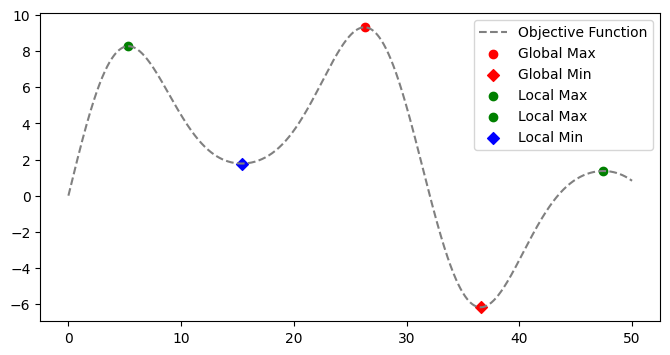

In [ ]:
# Plot Objective Function with Optima Labeled

def objective(x:np.array)->np.array:
    return (np.sin(0.2 * x) * np.cos(0.1 * x) * 10 +
            np.sin(0.5 * x) + 0.05 * x)

x = np.linspace(0, 50, 1000)
y = objective(x)

plt.figure(figsize=(8, 4))
plt.plot(x, y, label="Objective Function", c="gray", linestyle="--")
plt.scatter(x[np.argmax(y)], np.max(y), label="Global Max", c="r")
plt.scatter(x[np.argmin(y)], np.min(y), label="Global Min", c="r", marker="D")
plt.scatter(x[np.argmax(y[:200])], np.max(y[:200]), label="Local Max",
            c="g", marker="o")
plt.scatter(x[np.argmax(y[800:]) + 800], np.max(y[800:]), label="Local Max",
            c="g", marker="o")
plt.scatter(x[np.argmin(y[200:400]) + 200], np.min(y[200:400]),
            label="Local Min", c="b", marker="D")
plt.legend()
plt.show()

It must be emphasized that the use of NumPy's functions for finding the
argument (location) and value for each minimum/maximum is purely for
the purposes of visualization. In optimization, we would typically want to avoid 
computing the objective function at each location in the space but rather use
methods to find the optima in a more efficient manner.

### Objective Functions

The **objective function** is the function that we want to optimize. For some
problems, there is a mathematical model that can be developed to describe the
objective. However, in many real-world applications, there is no analytical or
mathematical model to describe the objective (one of the motivations for
Bayesian optimization).

Some objective functions are convex with only a single, unique global minimum
or maximum. Other functions are non-convex and might have several local optima
or a flat region with many saddle points. The plot below shows these three
general types of objectives.

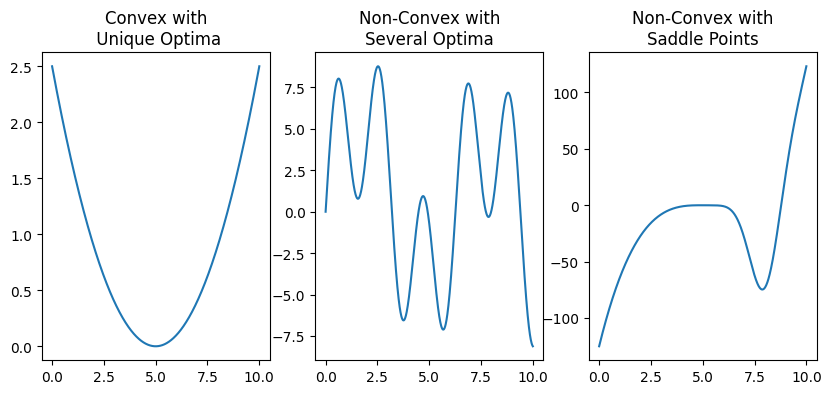

In [162]:
# Plot General Types of Objective Functions

def objective_convex(x:np.array)->np.array:
    return 0.1*(x - 5)**2

def objective_non_convex(x:np.array)->np.array:
    return np.sin(2*x) * np.cos(x) * 10 + np.sin(0.5 * x) + 0.05 * x

def objective_non_convex_saddle(x:np.array)->np.array:
    return (x - 5)**3 - 100 * np.exp(-((x - 8)**2))

x = np.linspace(0, 10, 1000)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
ax[0].plot(x, objective_convex(x))
ax[0].set_title("Convex with\n Unique Optima")
ax[1].plot(x, objective_non_convex(x))
ax[1].set_title("Non-Convex with\nSeveral Optima")
ax[2].plot(x, objective_non_convex_saddle(x))
ax[2].set_title("Non-Convex with\nSaddle Points")
plt.show()

While the plots showing non-convex objective functions pose difficulty to
efficiently optimize such functions, there are other characteristics (listed
below) of objective functions common in Bayesian optimization that also lead to
issues.
 * The objective is considered to be a ``black-box`` function meaning we can
   only interact with the objective via its inputs and outputs.

 * The objective's returned value is corrupted by some sort of noise and does
   not represent the exact true objective value at that location.

 * The cost of evaluating the objective function is high and requires a
   sample efficient method to avoid expensive probing.

 * There do not exist gradients (if we did, efficient gradient-based methods
   could be employed to locate and evaluate optima).

### Observation Models

Observation models are similar to the idea of surrogate models used in the
Bayesian optimization workflow but there are some key differences. The observation is used to describe how the true objective is _observed_, usually
accounting for some form of noise. On the other hand, the surrogate model is
a probabilistic model (i.e., Gaussian process) used to approximate the unknown
objective function.

Specifically, the **observation model** is an approach to formalize the
relationship between the true objective function, the actual observation, and
the noise. This is rather important since the model used to relate the true
objective and actual observations must account for uncertainty due to noise.
Mathematically, this is the probability distribution of $y$ given the sample
location $x$ and true objective function $f$:

\begin{equation*}
    p(y \vert f, x)
\end{equation*}

To account for uncertainty, we assume that the observations are _stochastically_
dependent on the objective. Mathematically, we assume an additive noise term
$\varepsilon$:

\begin{equation*}
    y = f(x) + \varepsilon
\end{equation*}

Let $\varepsilon \sim \mathcal{N}(0, \sigma^2)$. Then, the model becomes:

\begin{equation*}
    p(y \vert x, f, \sigma) = \mathcal{N}(y; f, \sigma^2)
\end{equation*}

Thus, the observation $y$ at sample location $x$ is treated as a _random_
_variable_ which follows a Gaussian, or normal, distribution with mean $f$ and
variance $\sigma^2$. This leads to the distribution of $y$ being centered around
the true objective value at sample location $x$, $f(x)$.

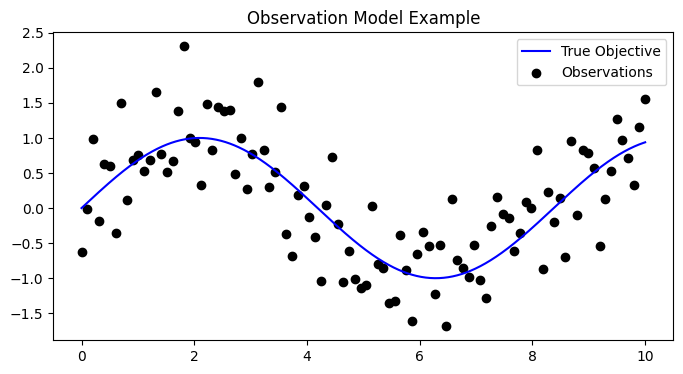

In [153]:
# Plot Example Observation Model

def true_objective(x:np.array)->np.array:
    return np.sin(0.75 * x)

def observation(x:np.array, sd:float)->np.array:
    return true_objective(x) + np.random.normal(0, sd, x.shape)

x = np.linspace(0, 10, 1000)
samples = np.linspace(0, 10, 100)

plt.figure(figsize=(8, 4))
plt.plot(x, true_objective(x), label="True Objective", c="b")
plt.scatter(samples, observation(samples, sd=0.5), label="Observations", c="k")
plt.title("Observation Model Example")
plt.legend()
plt.show()

In the plot above, the true objective is shown in addition to 100 observations
that have an additive term of random (Gaussian, or normal) noise. The
observation model will need to take this into account since noise, often called
_uncertainty_ in Bayesian optimization, is inherent in real-world problems. It
can come from measurement errors, environmental factors, or simply the
randomness in the system being optimized.

### Optimization Policies

In simple terms, the optimization policy handles the repeated interactions
between the "inner-workings" of the policy and the environment, with the
environment typically being _noise-corrupted_ (hence the need for an observation
model).

More definitive, a **policy** is a mapping function that takes in a new input
observation plus any existing observations and uses a _principled_ sampling
approach to output the next observation location. It will also decide if it
should perform another iteration (select a new observation) or terminate the
optimization process (see _Termination Policies_ below).

For most applications, we want the policy to ideally be learning and improving
such that it will guide the search toward the global optimum more effectively.
Furthermore, the iterative policy improvement should lead to a good policy that
retains the (typically limited) sampling budget for more promising candidate
points. A policy that does not consider observed data are known as a
_non-adaptive_ policy and is not ideal for costly observations.

Note that in some literature, there is little distinction between the
optimization policy and the termination policy (discussed next). To be clear,
the termination policy is one of the several components that make up the
optimization policy. This lack of distinction is not unreasonable but rather
something to be aware of when reviewing the vast literature on optimization.

### Termination Policies

A **termination policy** is the final decision in the optimization loop. The
policy decides whether to terminate immediately or continue with another
observation (continue to optimize the objective). Such policies can be
_deterministic_ or _stochastic_.
 * A **deterministic termination policy** is one that will stop the optimization
   process after reaching a goal or exhausting a pre-defined search budget.

 * A **stochastic termination policy** is one that will depend on the observed
   data and some level of randomness or probability.

Note that this piece of the optimization process can be handled by an external
agent or be dynamic (i.e., a deterministic or stochastic termination policy).
For the purposes of this notebook, we will not focus on specific termination
policies here. This is primarily due to the fact that the termination policy
depends heavily on the approach or method and the problem/application.

### Diagram of the Optimization Process

<img src="graphics/01-introduction/opt-foundations/process-diagram.png"
     alt="Optimization Process Diagram" width=600/>

## Bayesian Foundations

Before we venture into the world of Bayesian optimization, we must first review
some foundations of Bayesian statistics. For a more comprehensive examination of
Bayesian statistics, the reader is referred to _Mathematical Statistics and_
_Data Analysis_ by John A. Rice or _Bayesian Optimization_ by Roman Garnett
(which provides an optimization-focused review).

In Bayesian optimization, we use Bayesian statistics to reason in a systematic
and quantitative manner about the uncertainty in the observation (surrogate)
model using probabilities.

One of the core ideas in Bayesian statistics is **Bayesian inference**. Bayesian
inference uses Bayes' Theorem to reason about how the prior distribution
$p(\theta)$, the likelihood $p(\text{data}\vert\theta)$, and the posterior
distribution $p(\theta\vert\text{data})$ interact with each other (where
$\theta$ represents the parameter of interest). Bayes' Theorem is given below:

\begin{equation*}
    p(\theta\vert\text{data}) = \frac{p(\text{data}\vert\theta)p(\theta)}
        {p(\text{data})}
\end{equation*}

Let's back up a bit and break this down. First, in simpler terms, Bayesian
inference is a framework used to infer uncertain features (variables) of a
particular system of interest from observations using the laws of probability.

Within Bayesian inference framework, all unknown quantities are considered to
be _random variables_. This enables us to represent our beliefs with probability
distributions that reflect plausible values. We begin first with a **prior**
**distribution**, $p(\theta)$ that represents our beliefs before seeing any
data. For instance, if we believe that the data is normally distributed then we
would define the prior distribution to be the Gaussian normal distribution with
mean $\mu$ and standard deviation $\sigma$.

Next, we are able to refine our initial beliefs after we have observed some data
using the **likelihood** $p(\text{data}\vert\theta)$. The likelihood, or
likelihood function, provides the distribution of observed values ($y$) given
the location $(x)$ and values of interest ($\theta$).

Using the observed value $y$, we can derive the **posterior distribution** of
$\theta$ using Bayes' theorem, as defined previously.

\begin{equation*}
    p(\theta\vert x, y) = \frac{p(\theta)p(y\vert x, \theta)}{p(y\vert x)}
\end{equation*}

This so-called posterior distribution represents a "compromise" between our
beliefs or experience from the prior and our observations from the likelihood.
The posterior distribution is at the heart of Bayesian optimization since we use
it to update the surrogate model as we acquire new observations.

### Bayesian Inference of the Objective Function

The primary use of Bayesian inference in Bayesian optimization is with respect
to the objective function, the source of uncertainty. The probabilistic belief
we use over the objective function is called a _stochastic process_.

A **stochastic process** is a probability distribution over an infinite
collection of random variables, for example, the objective function value at
every point in the domain.

We will express any assumptions that we may have about the objective function
in a **prior process** $p(\mathcal{f})$. Then, a stochastic process can be
defined via the distribution of the function values $\boldsymbol{\phi}$ given a
finite set of points $\boldsymbol{x}$:

\begin{equation*}
    p(\boldsymbol{\phi}\vert\boldsymbol{x})
\end{equation*}

In Bayesian optimization, the gold standard stochastic process is the
**Gaussian process** since many of these finite-dimensional distributions are
multivariate Gaussian (or approximately so).

Returning to the discussion of Bayesian inference over the objective, suppose we
make a set of observations at locations $\boldsymbol{x}$ with corresponding
vaulues $\boldsymbol{y}$. Let $\mathcal{D} = (\boldsymbol{x},\boldsymbol{y})$ be
the dataset of aggregated observations.

Bayesian inference will account for these observations via the formation of the
**posterior process** (akin to the posterior predictive distribution):

\begin{equation*}
    p(\mathcal{f}\vert\mathcal{D}) =
    \int p(\mathcal{f}\vert\boldsymbol{x},\boldsymbol{\phi})
    p(\boldsymbol{\phi}\vert\mathcal{D})\hspace{2pt}\text{d}\boldsymbol{\phi}
\end{equation*}

## The Bayesian Approach

The notion of the "Bayesian approach" (particularly in the context of
optimization) refers to a philosophical approach derived from Bayesian
inference. The Bayesian approach allows us to tackle uncertainty inherent in
optimization decisions, a crucial property since decisions will determine our
success. To do this, it systematically relies on probability laws and Bayesian
inference to reason about uncertainty during optimization.

For instance, as briefly discussed in the previous section, the objective
function is regarded as a random variable that is to be informed by our prior
expectations and prior observations. This approach will play an active role in
the optimization as it will guide the optimization policy, specifically by
evaluating the merit of a candidate observation. Furthermore, it leads to the
development of **uncertainty-aware optimization policies**.

### Uncertainty-Aware Optimization Policies

Recall that the optimization policy determines the decisions, or actions, taken
during the optimization process. In order to handle the uncertainty of the
(potentially unknown or black-box) objective function, the policy should examine
the available data (i.e., pre-existing observations and corresponding values) to
determine the each successive observation location optimally. The only
requirement from ourselves is to establish our preferences for what data or what
kind of data we want to acquire and then maximize such preferences.

Clearly, this will require some sort of framework to make decisions in this way,
especially in the face of uncertainty. A natural choice is **Bayesian decision**
**theory** which will be discussed in more detail in another notebook.

As we continue to explore Bayesian optimization and uncertainty-aware policies,
a common theme will begin to emerge: all Bayesian optimization policies handle
the uncertainty in the objective function in a uniform manner, a property that
is defined implicitly within an optimal _acquisition function_.

## Bayesian Optimization Workflow

The Bayesian optimization workflow is composed of two main _primitives_: the
surrogate model for expressing our beliefs and knowledge about the objective
function, and the acquisition function that will guide the optimization policy
to make optimal decisions about where to observe next. In this section, we will
briefly discuss these two primitives to understand how they fit into this
workflow. Note that these topics will be discussed more thoroughly in other
notebooks.

### Surrogate Models

**Surrogate models** are the models that we use to express our beliefs and
knowledge about the objective function. While in some literature the term
_observation model_ is used interchangeably with _surrogate model_, they are
distinguishable. In most applications, if we know some sort of mathematical
formulation of the true objective then we refer to the model that relates the
observations and the true objective as an _observation model_. However, if we
do not know the underlying structure (as is the case with black-box functions),
we refer to the model as a _surrogate model_ since it "takes the place of" and
acts "as a surrogate of" the true underlying objective function.

The specific use of the surrogate model is usually when we use the predictive
posterior distribution (posterior process) to quantify the probabilities of
observations usually in conjunction with utility functions. Therefore, the
surrogate model is a powerful tool when we are reasoning about both the
uncertainty and utility of candidate observations.

Recall that the probability distributions of an infinite collection of random
variables are jointly used as a _stochastic process_ that is used to
characterize the true objective function. In Bayesian optimization, a common
choice for the surrogate model in the family of stochastic processes is the
**Gaussian process**. It is very common due to its flexibility, expressivity,
and sufficient uncertainty quantification properties. For Gaussian processes
specifically, the uncertainty is quantified via the credible interval but we
will discuss such processes in more detail later.

### Acquisition Functions

**Acquisition functions** assign a score to candidate observations with the
score representing the potential benefit the observation will add to the
optimization process. Ideally, acquisition functions are cheap to evaluate and
should address the _exploitation-exploration tradeoff_. Within this tradeoff,
exploitation refers to sampling where the objective function value is expected
to be large while exploration refers to sampling where we are more uncertain
about the value of the objective function. Another important property of an
acquisition function is that it will vanish at pre-existing observations where
the objective function value is already known (no sense in sampling twice).

The optimization policy should be designed to maximize the acquisition function
such that we select the candidate observation with the most potential to benefit
the optimization process. There are two general cases of acquisition function:
myopic and look-ahead. Myopic acquisition functions only consider the immediate
utility while look-ahead acquisition functions will consider longer-term utility
(see the notebook on decision theory for more information).

Finally, the policy that uses a particular acquisition function can be
evaluated using **instant (simple) regret**. Instant regret measures the
distance between the current and optimal locations whereas cumulative regret
measures the cumulative distance between historical locations and the optimum
location.

## References

For full-reference details, the BibTeX entries can be found in the
`bibliography.bib` file.

 * _Bayesian Optimization_ by Roman Garnett (2023)
 * _Bayesian Optimization: Theory and Practice Using Python_ by Peng Liu (2023)
 * _Gaussian Processes for Machine Learning_ by Rasmussen & Williams (2019)